In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
! nvidia-smi -L

GPU 0: Quadro RTX 6000 (UUID: GPU-26dfa6b3-88ef-1e87-ba91-3ca0255166ab)
GPU 1: Quadro RTX 6000 (UUID: GPU-2c315734-0ffc-e8d8-40fb-29a2ccd25ab5)
GPU 2: Quadro RTX 6000 (UUID: GPU-057fcb77-7816-2825-8db8-b78905930b06)
GPU 3: Quadro RTX 6000 (UUID: GPU-dc56feb4-523f-6ded-e577-4416c9dc6561)


In [4]:
stream = "gd1_tail"

In [5]:
df = load_file(stream = stream, percent_bkg = 10)

Before reduction, stream stars make up 0.039% of the dataset.
After reduction, stream stars make up 0.384% of the dataset.


Exclude a hotspot:

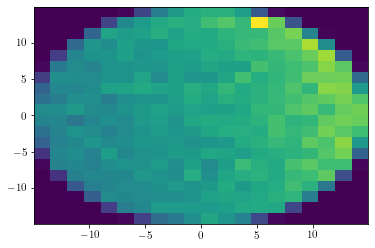

In [6]:
hist = plt.hist2d(df.α, df.δ, bins=20)

In [7]:
hist[0].max()

643.0

In [8]:
# Get indices for bins to exclude
i, j = np.unravel_index(hist[0].argmax(), hist[0].shape)
print(i,j)

13 18


In [9]:
print(hist[1][13],hist[1][14])
print(hist[1][18],hist[1][19])

4.497667072600137 5.99738206348178
11.99624202700835 13.495957017889992


In [10]:
df2 = df[(df.α < hist[1][13]) | (df.α > hist[1][14]) | 
         (df.δ < hist[1][18]) | (df.δ > hist[1][19])]

In [11]:
100*len(df2)/len(df)

99.46171152403966

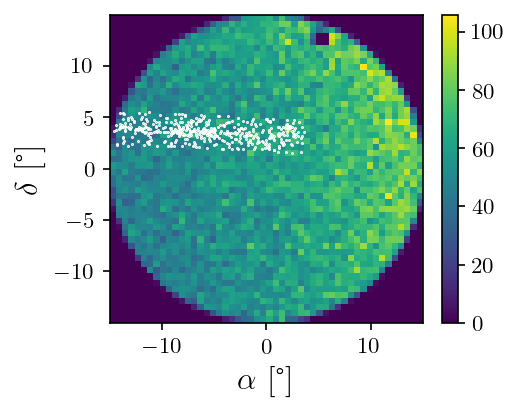

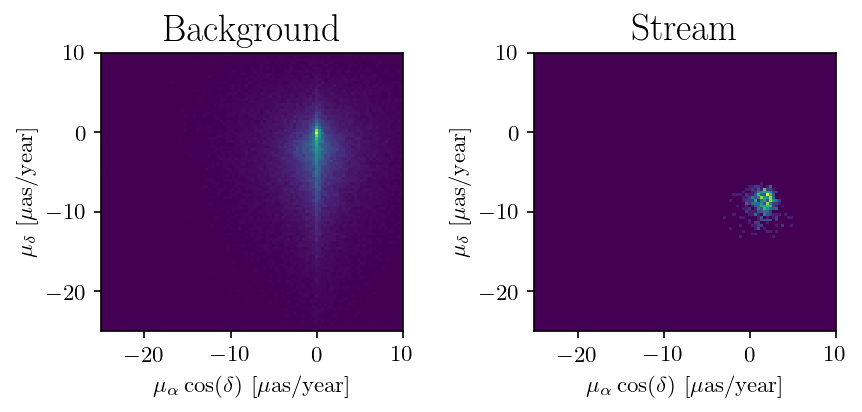

In [12]:
visualize_stream(df2)

In [13]:
df = df2

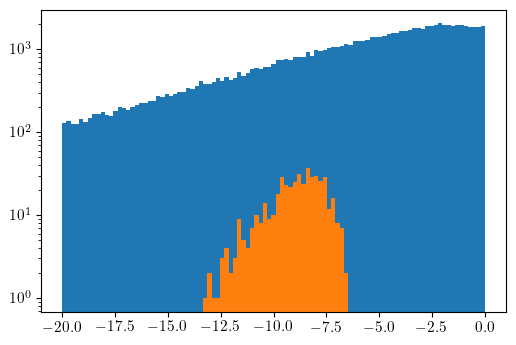

In [14]:
bins=np.linspace(-20,0,100)
plt.figure(dpi=100)
plt.hist(df.μ_δ, bins=bins);
plt.hist(df[df.stream == True].μ_δ, bins=bins);
plt.yscale('log')

-11 -10 -8 -7
Total counts: SR = 7,923, SB = 7,952
Signal region has 256 stream and 7,667 bkg events.
Sideband region has 148 stream and 7,804 bkg events.


/clusterfs/ml4hep/mpettee/GaiaCWoLa/functions.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)


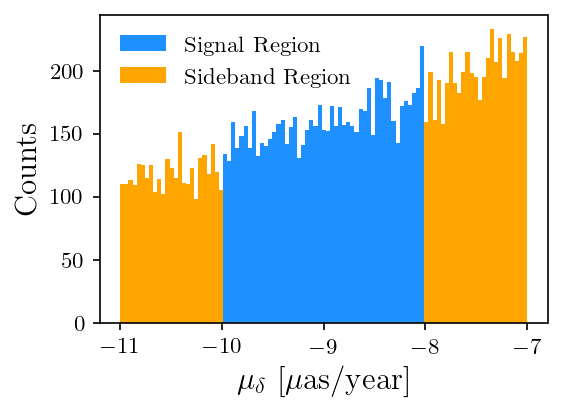

In [15]:
df_slice = signal_sideband(df, stream = stream)

In [16]:
### Prepare datasets for training
if 'color' in df.keys(): 
    training_vars = ['μ_α','δ','α','color','mag']
elif 'b-r' in df.keys():
    training_vars = ['μ_α','δ','α','g','b-r']
train, validate, test = np.split(df_slice.sample(frac=1), [int(.7*len(df_slice)), int(.85*len(df_slice))]) # 70/15/15 train/validate/test split

x_train, x_val, x_test = [train[training_vars], validate[training_vars], test[training_vars]]
y_train, y_val, y_test = [train.label, validate.label, test.label]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

print("Training on {:,} events.".format(len(train)))

Training on 11,112 events.


In [61]:
### Define model architecture 
layer_size = 30
dropout = 0.1
reg = regularizers.l2(1e-2)

model = Sequential()
model.add(Dense(layer_size, input_dim=len(training_vars), activation='relu',
               activity_regularizer=reg
               )) 
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=reg
               ))
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=reg
               ))
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

# stops if val_loss doesn't improve for [patience] straight epochs
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=10, 
                                         verbose=1) 

# saves weights from the epoch with lowest val_loss 
checkpoint = callbacks.ModelCheckpoint("weights.h5", 
                                       monitor='val_loss', 
                                       mode='auto', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       save_weights_only=True)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 30)                180       
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_10 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)               

In [62]:
# # Add k-folding
# kfold = KFold(n_splits=5, shuffle=True)
# fold_number = 1
# for train, test in kfold.split(x_train, y_train):
#     ### Define model architecture 
#     layer_size = 50
#     dropout = 0.
#     reg = regularizers.l2(1e-3)

#     model = Sequential()
#     model.add(Dense(layer_size, input_dim=len(training_vars), activation='relu',
#                    activity_regularizer=reg
#                    )) 
#     if dropout != 0: 
#         model.add(Dropout(dropout))
#     model.add(Dense(layer_size, activation='relu',
#                    activity_regularizer=reg
#                    ))
#     if dropout != 0: 
#         model.add(Dropout(dropout))
#     model.add(Dense(layer_size, activation='relu',
#                    activity_regularizer=reg
#                    ))
#     if dropout != 0: 
#         model.add(Dropout(dropout))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', 
#                   optimizer='adam', 
#                   metrics=['accuracy'])
# #     model.summary()

#     # stops if val_loss doesn't improve for [patience] straight epochs
#     early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
#                                              patience=30, 
#                                              verbose=1) 

#     # saves weights from the epoch with lowest val_loss 
#     checkpoint = callbacks.ModelCheckpoint("weights.h5", 
#                                            monitor='val_loss', 
#                                            mode='auto', 
#                                            verbose=1, 
#                                            save_best_only=True, 
#                                            save_weights_only=True)

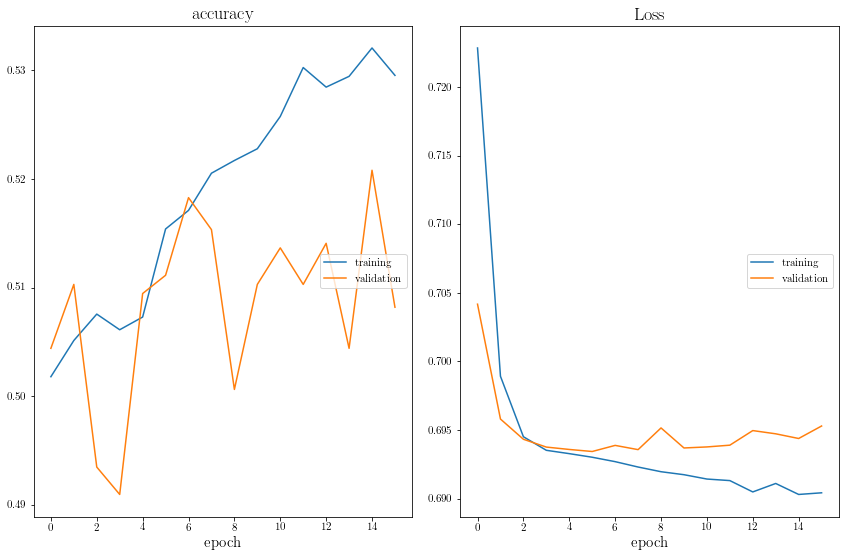

accuracy
	training         	 (min:    0.502, max:    0.532, cur:    0.530)
	validation       	 (min:    0.491, max:    0.521, cur:    0.508)
Loss
	training         	 (min:    0.690, max:    0.723, cur:    0.690)
	validation       	 (min:    0.693, max:    0.704, cur:    0.695)

Epoch 00016: val_loss did not improve from 0.69343
Epoch 00016: early stopping


In [63]:
### Train!
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32,
                    validation_data=(x_val,y_val),
                    callbacks = [PlotLossesKeras(),checkpoint,early_stopping],
                    verbose = 2,
                   )

AUC: 0.503
Maximum purity of 8.0% at 15.16%
Top 0.001% stars: Purity = 0.0% 
Top 0.01% stars: Purity = 0.0% 
Top 0.1% stars: Purity = 0.0% 
Top 1% stars: Purity = 0.0% 
Top 5% stars: Purity = 3.3% 
Top 10% stars: Purity = 7.1% 
Top 20% stars: Purity = 6.3% 


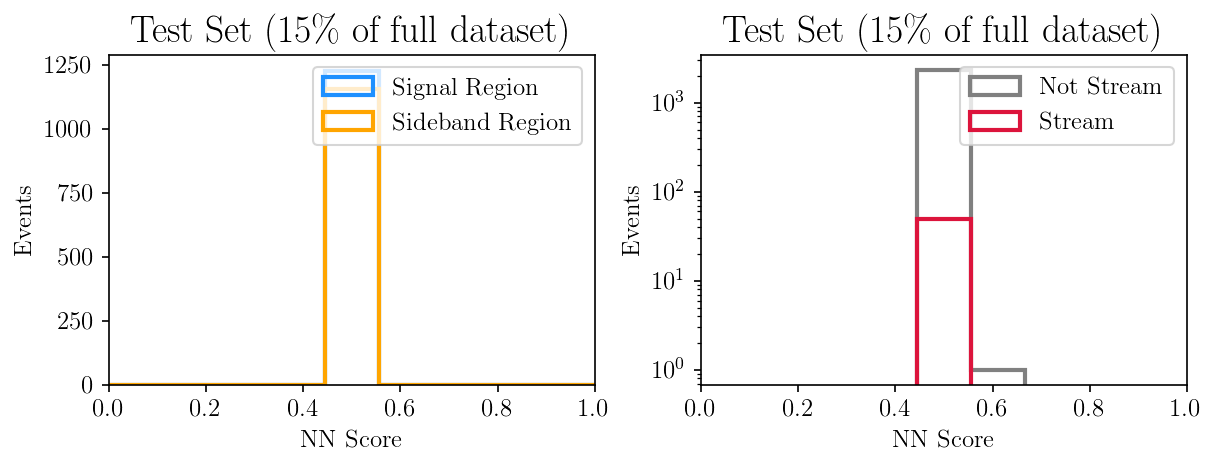

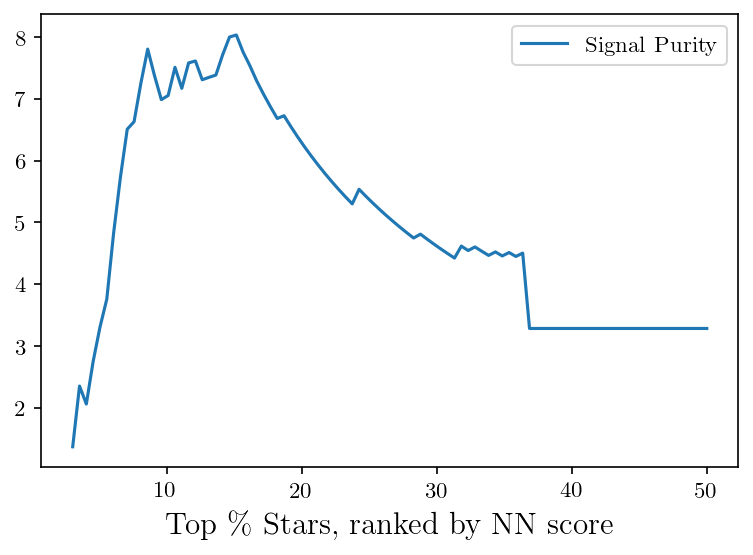

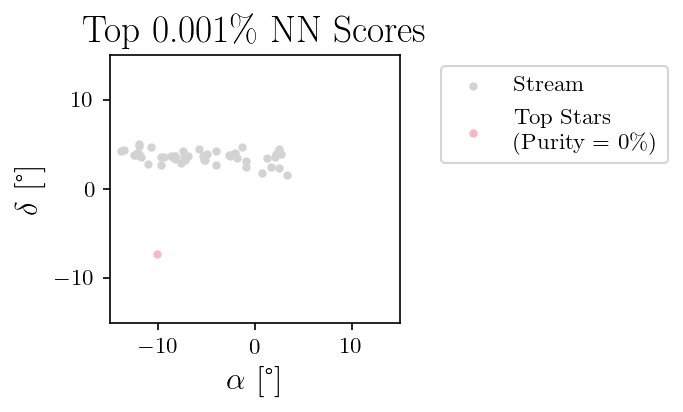

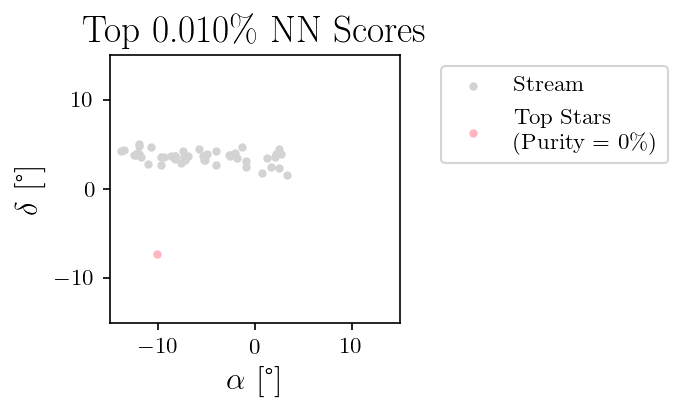

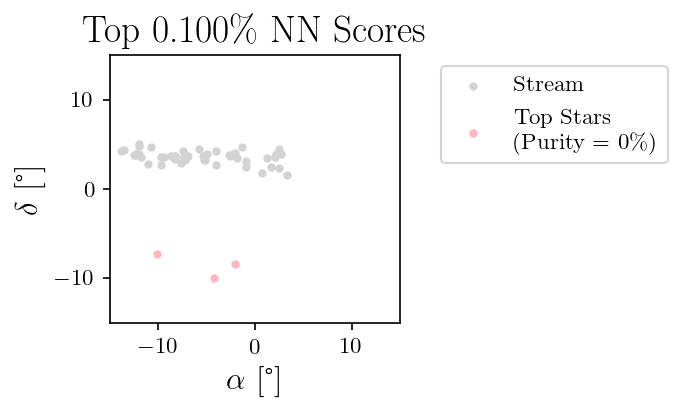

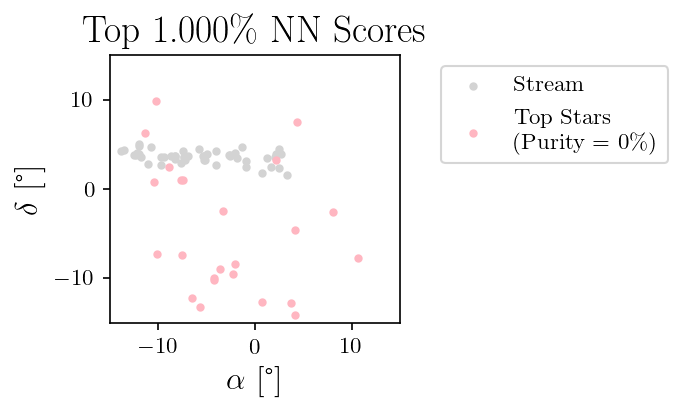

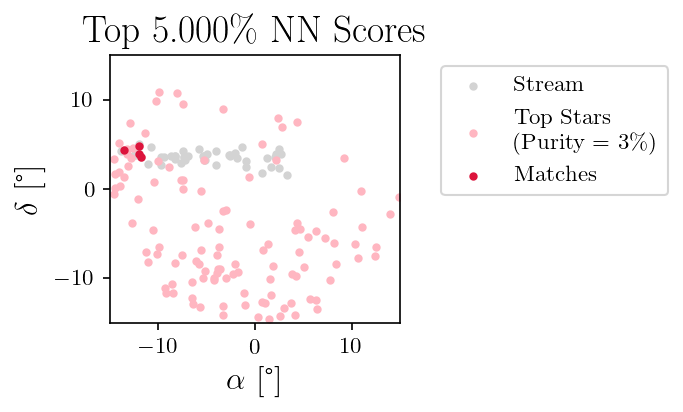

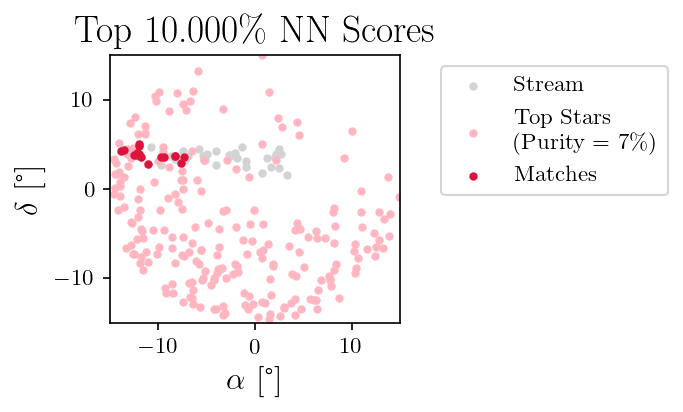

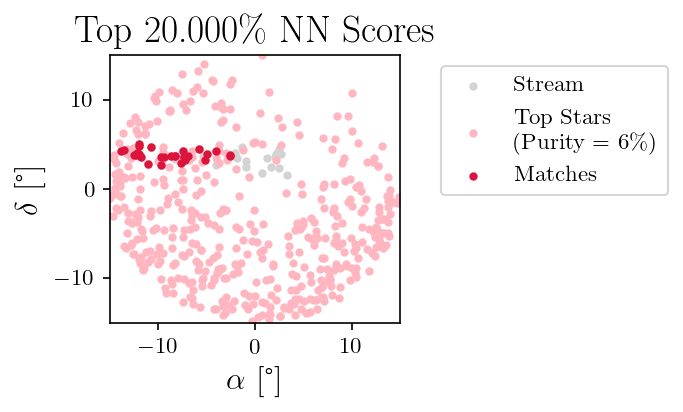

In [64]:
### Load best weights
model.load_weights("weights.h5")

### Add the NN prediction score to the test set: 
test["nn_score"] = model.predict(x_test)
fake_eff_baseline, real_eff_baseline, thresholds = roc_curve(np.asarray(y_test), test.nn_score)
auc_baseline = auc(fake_eff_baseline, real_eff_baseline)
print("AUC: {:.3f}".format(auc_baseline))

### Plot scores:
plot_results(test)